In [273]:
import pandas as pd
import numpy as np
import sys
import os
from IPython.display import display
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from simpledbf import Dbf5
import openmatrix as omx
import re
import geopandas as gpd
from shapely.geometry import Point, LineString

TRANSIT_INPUT = r'E:\Met_Council\metc-asim-model\Input_2022\transit\PT_2022.lin'
NODES = gpd.read_file(r'E:\Met_Council\metc-asim-model\Base_2022\transit\node.dbf')
MODEL_OUTPUT = r'E:\Met_Council\metc-asim-model\Base_2022'
OBS_SURVEY_PATH = r'E:\Met_Council\survey_data\Phase2\OBS_survey'
ITERATION = 0
ASIM_EXPANSION_FACTOR = 0.20767

# obs_survey = pd.read_excel(os.path.join(OBS_SURVEY_PATH, 'Met Council OD 2022.xlsx'), "data")
# obs_survey.to_pickle(os.path.join(OBS_SURVEY_PATH, 'obs_survey.pkl'))
obs_survey = pd.read_pickle(os.path.join(OBS_SURVEY_PATH, 'obs_survey.pkl'))

In [274]:
def read_card(input_file, group_id, key_id, nxy_table):
    with open(input_file, 'r') as fr:
        lines = fr.readlines()
    lines = [line.rstrip('\n') for line in lines]
    lines = [line for line in lines if line[0] != ';']
    lines = ''.join(lines)
    lines = lines.split(group_id)
    lines = [dict(re.findall(r'(\S+)\s*\=\s*(.*?)\s*(?=\S+\s*\=|$)', line)) for line in lines]
    out_lines = []
    for line in lines:
        if 'NAME' in line.keys():
            x = {}
            x['route_id'] = line['NAME']
            for k, v in line.items():
                if not k in ['NAME', 'N']:
                    x[k] = v.replace('"',"").replace(',','')
            coords = nxy_table.loc[[abs(int(n)) for n in line['N'].replace('\n','').replace(' ', '').split(',')]]
            geom = LineString([tuple(x) for x in coords.to_numpy()])
            x['geometry'] = geom
            out_lines.append(x)             
    return out_lines

In [275]:
model_transit_lines = gpd.GeoDataFrame(read_card(r'E:\Met_Council\metc-asim-model\Input_2022\transit\PT_2022.lin', 'LINE', 'NAME', NODES[['N', 'X', 'Y']].set_index('N')))

#.to_file('trn_routes.shp')

# ActivitySim Output

This is for diagnostics

In [276]:
# Read Asim Outputs
tours = pd.read_csv(os.path.join(MODEL_OUTPUT, 'ActivitySim', 'output', 'final_tours.csv'))
trips = pd.read_csv(os.path.join(MODEL_OUTPUT, 'ActivitySim', 'output', 'final_trips.csv'))


C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_22488\2205018176.py:2: DtypeWarning: Columns (16,28) have mixed types. Specify dtype option on import or set low_memory=False.
  tours = pd.read_csv(os.path.join(MODEL_OUTPUT, 'ActivitySim', 'output', 'final_tours.csv'))


In [277]:
trn_mode_period = []
for period in ['EA', 'AM', 'MD', 'PM', 'NT']:
    try:
        omx_file = omx.open_file(os.path.join(MODEL_OUTPUT, 'ActivitySim', 'output', f'transit_{period}.omx'), 'r')
        for table in omx_file.list_matrices():
            print(f"Period: {period}, table: {table}, sum: {np.array(omx_file[table]).sum()}")
            trn_mode_period.append([period, table, np.array(omx_file[table]).sum()])

    finally:
        omx_file.close()
        print("File closed")

trn_mode_period = pd.DataFrame(trn_mode_period, columns = ['period', 'table', 'trips'])


Period: EA, table: DriveToTransit, sum: 917.5257731958776
Period: EA, table: TrnDriveEgress, sum: 1582.4742268041236
Period: EA, table: WalkToTransit, sum: 3293.8144329896854
File closed
Period: AM, table: DriveToTransit, sum: 11556.701030927845
Period: AM, table: TrnDriveEgress, sum: 1809.2783505154644
Period: AM, table: WalkToTransit, sum: 20030.92783505154
File closed
Period: MD, table: DriveToTransit, sum: 6865.979381443303
Period: MD, table: TrnDriveEgress, sum: 5953.608247422683
Period: MD, table: WalkToTransit, sum: 23752.577319587625
File closed
Period: PM, table: DriveToTransit, sum: 4556.701030927836
Period: PM, table: TrnDriveEgress, sum: 12582.474226804123
Period: PM, table: WalkToTransit, sum: 26969.07216494845
File closed
Period: NT, table: DriveToTransit, sum: 2103.092783505155
Period: NT, table: TrnDriveEgress, sum: 7113.402061855672
Period: NT, table: WalkToTransit, sum: 13350.515463917563
File closed


In [278]:
model_pertrip_totals = pd.concat([
    trn_mode_period.pivot(index = 'period', columns = 'table', values = 'trips'),
    trn_mode_period.groupby('table').agg(trips = ('trips', 'sum')).assign(period = 'Total').reset_index().pivot(index = 'period', columns = 'table', values = 'trips')
])

model_linked_trips = model_pertrip_totals[model_pertrip_totals.index == 'Total'].sum(1)

model_pertrip_totals.style.format('{:,.0f}')

table,DriveToTransit,TrnDriveEgress,WalkToTransit
period,,,
AM,"11,557","1,809","20,031"
EA,918,"1,582","3,294"
MD,"6,866","5,954","23,753"
NT,"2,103","7,113","13,351"
PM,"4,557","12,582","26,969"
Total,"26,000","29,041","87,397"


In [279]:
trnload = {}

for per in ['EA', 'AM', 'MD', 'PM', 'NT']:
    for am in ['WK', 'DR', 'DE']:
        trnload[f'{per}_{am}'] = Dbf5(os.path.join(MODEL_OUTPUT, 'transit', f'XIT_{am}_LD_{ITERATION}_{per}.dbf')).to_dataframe()


# Read Survey Data

In [280]:
obs_survey['ROUTE_NAME'] = obs_survey['ROUTE_DIRECTIONCode'].apply(lambda x: x[x.find("_") + 3: x.rfind("_")])
obs_ridership = obs_survey.groupby('ROUTE_NAME').agg(obs_ridership = ('Final_unlinked_weight_fctr', 'sum')) #, wtd_linked_trips = ('Final_Linked_weight_fctr', 'sum'))

In [281]:
obs_transfer = obs_survey.Final_unlinked_weight_fctr.sum() / obs_survey.Final_Linked_weight_fctr.sum()
print(f"Survey trips: {obs_survey.Final_Linked_weight_fctr.sum():,.0f}; ridership: {obs_survey.Final_unlinked_weight_fctr.sum():,.0f}; tranfer rate is {obs_transfer: ,.4f}")

Survey trips: 124,008; ridership: 147,929; tranfer rate is  1.1929


# Read Model Output

In [282]:
trn_summary = pd.concat(trnload)
# trn_summary.groupby('MODE').agg(distance = ('DIST', 'sum'), time = ('TIME', 'sum'), boards = ('ONA', 'sum')).assign(speed = lambda x: x['distance'] / (x['time'] / 60.0))

In [283]:
trn_summary['ROUTE_NAME'] = ''
trn_summary.loc[trn_summary['NAME'].str.find("_") > 0, 'ROUTE_NAME'] = trn_summary['NAME'].apply(lambda x: x[:x.find("_")])

trn_summary.groupby(['NAME', 'MODE', 'OPERATOR']).agg(boards = ('ONA', 'sum')).to_excel("trn_line_summ.xlsx")
trn_valid_summary = obs_ridership.join(trn_summary[~trn_summary['NAME'].isin(['*1', '*2', '*3', '*4'])].groupby(['ROUTE_NAME', 'MODE']).agg(DIST = ('DIST', 'sum'), TIME = ('TIME', 'sum'), model_ridership = ('ONA', 'sum')), how = 'left')

trn_valid_summary.to_excel('transit_loadings.xlsx')

In [284]:
pd.DataFrame(trn_valid_summary[['model_ridership', 'obs_ridership']].sum()).style.format('{:,.0f}')

,0
model_ridership,"146,361"
obs_ridership,"147,691"


In [285]:
mod_transfer = trn_valid_summary['model_ridership'].sum() / model_linked_trips['Total']
print(f"Observed Transfer Rate: {obs_transfer:0.2f}; Model Transfer Rate: {mod_transfer: 0.2f}")

Observed Transfer Rate: 1.19; Model Transfer Rate:  1.03


In [286]:
vmt_diff = trn_valid_summary['model_ridership'].sum() - trn_valid_summary['obs_ridership'].sum()
pct_diff = vmt_diff / trn_valid_summary['obs_ridership'].sum()
print(f"Difference: {vmt_diff:,.0f} ({pct_diff:.2%})")

Difference: -1,329 (-0.90%)


In [287]:
trn_valid_summary.reset_index(inplace = True)
trn_valid_summary['transit_mode'] = 'Bus'
trn_valid_summary.loc[trn_valid_summary['MODE'] == 8, 'transit_mode'] = 'LRT'
trn_valid_summary.loc[trn_valid_summary['MODE'] == 9, 'transit_mode'] = 'CRT'
mode_summary = pd.DataFrame(trn_valid_summary.groupby('transit_mode').agg(model = ('model_ridership', 'sum'), obs = ('obs_ridership', 'sum')))
mode_summary.loc['total'] = mode_summary.sum(0)
mode_summary['diff'] = mode_summary['model'] - mode_summary['obs']
mode_summary['pdiff'] = mode_summary['diff'] / mode_summary['obs']

mode_summary.style.format({'model': '{:,.0f}', 'obs': '{:,.0f}', 'diff': '{:,.0f}', 'pdiff':'{:,.1%}'})

,model,obs,diff,pdiff
transit_mode,,,,
Bus,"118,589","121,190","-2,601",-2.1%
CRT,"1,607",361,"1,246",345.1%
LRT,"26,165","26,139",26,0.1%
total,"146,361","147,691","-1,329",-0.9%


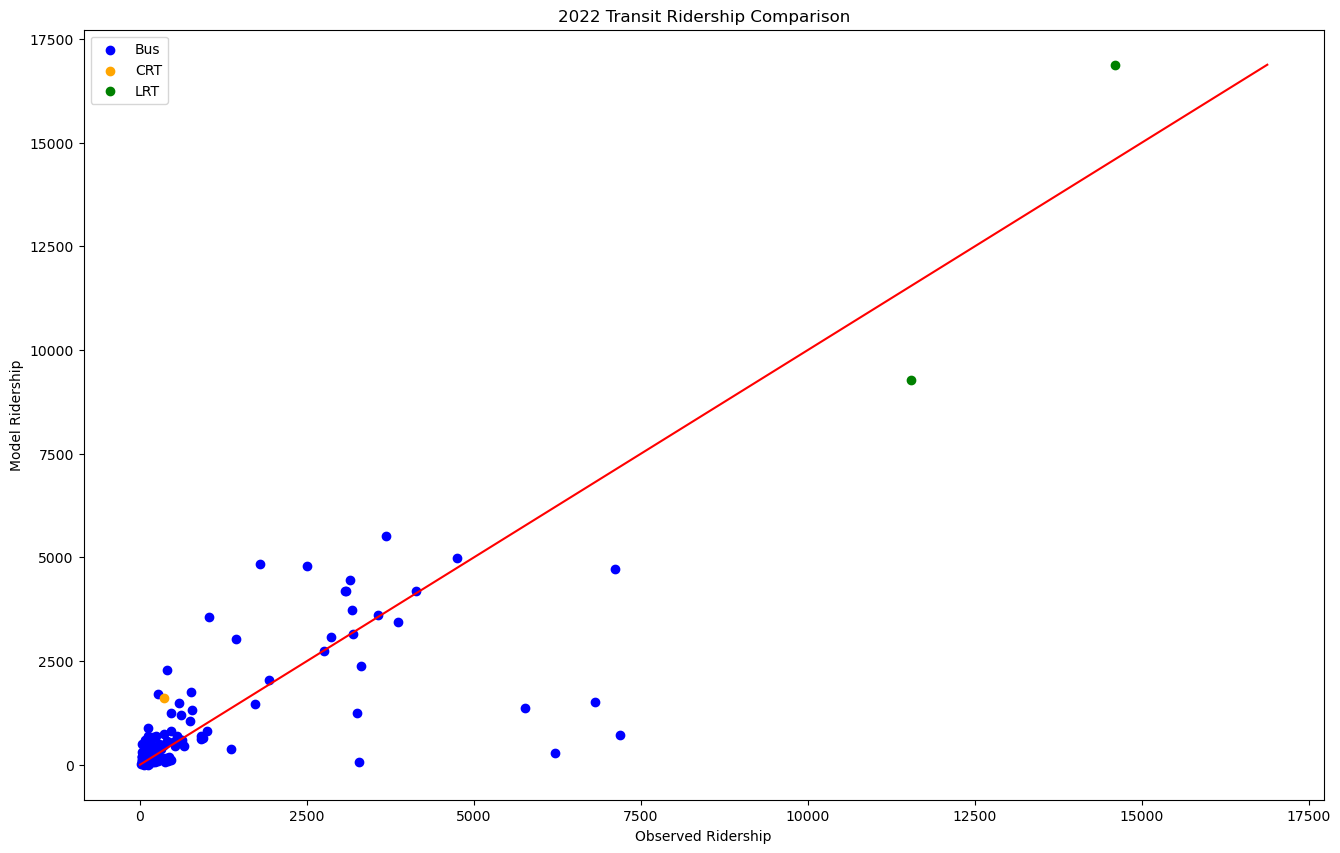

In [288]:
fig = plt.figure(figsize=(16,10))
color_guide = {'Bus': 'blue', 'LRT': 'green', 'CRT': 'orange'}
ax = fig.add_subplot()
sc = ax.plot([0, np.max(trn_valid_summary[['model_ridership', 'obs_ridership']].max())], [0, np.max(trn_valid_summary[['model_ridership', 'obs_ridership']].max())], c = 'red')
for m in trn_valid_summary['transit_mode'].unique():
    ax.scatter(trn_valid_summary[trn_valid_summary['transit_mode'] == m]['obs_ridership'], 
        trn_valid_summary[trn_valid_summary['transit_mode'] == m]['model_ridership'], marker='o', 
        c = color_guide[m], label = m)
plt.title("2022 Transit Ridership Comparison")

plt.legend(loc='upper left')
ax.set_xlabel('Observed Ridership')
ax.set_ylabel('Model Ridership')
plt.show()

In [289]:
model_transit_lines['ROUTE_NAME'] = model_transit_lines['route_id'].apply(lambda x: x[1:x.find("_")])
model_transit_lines['o_rider'] = np.array(trn_valid_summary.reset_index()[['ROUTE_NAME', 'obs_ridership']].set_index('ROUTE_NAME').reindex(model_transit_lines['ROUTE_NAME']).fillna(0))
model_transit_lines['m_rider'] = np.array(trn_valid_summary.reset_index()[['ROUTE_NAME', 'model_ridership']].set_index('ROUTE_NAME').reindex(model_transit_lines['ROUTE_NAME']).fillna(0))

# diff, abs_diff, pct_diff
model_transit_lines['diff'] = model_transit_lines['m_rider'] - model_transit_lines['o_rider']
model_transit_lines['a_diff'] = abs(model_transit_lines['diff'])
model_transit_lines['p_diff'] = model_transit_lines.apply(lambda x: x['diff'] / x['o_rider'] if x['o_rider'] > 0 else 0, axis = 1)

model_transit_lines.to_file('trn_routes.shp')